<a href="https://colab.research.google.com/github/WanjohiWanjohi/2021-Better-Working-World-Data-Challenge/blob/Add-azure-indexing/BushFires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# !pip install geopandas

     |████████████████████████████████| 1.0MB 5.6MB/s 
     |████████████████████████████████| 6.5MB 12.2MB/s 
     |████████████████████████████████| 15.3MB 204kB/s 


In [42]:
!pip install kneed


In [43]:
import pandas as pd
import numpy as np 
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [30]:
df_train = pd.read_csv('challenge1_train.csv' , date_parser=['dateTimeUTC' , 'dateTimeLocal'])
df_test = pd.read_csv('challenge1_test.csv' , date_parser=['dateTimeUTC' , 'dateTimeLocal'])
df_submission = pd.read_csv('sample_submission.csv')

Let's have a look at the data :
1. Columns and rows 
2. Data types
3. Null and not null rows
4. Unique items in labels 

In [16]:
#get shape of test and train 
df_train.shape , df_test.shape , df_submission.shape

((129, 4), (5000, 7), (5000, 2))

In [48]:
# data types 
df_train.dtypes , df_test.dtypes

(id                        int64
 label                    object
 dateTimeLocal    datetime64[ns]
 dateTimeUTC      datetime64[ns]
 month                     int64
 year                      int64
 dtype: object, id                        int64
 label                    object
 x                         int64
 y                         int64
 dateTimeLocal    datetime64[ns]
 dateTimeUTC      datetime64[ns]
 target                  float64
 month                     int64
 year                      int64
 dtype: object)

In [18]:
# null items 
pd.isna(df_train).sum().sum() , pd.isna(df_test).sum().sum()

(0, 5000)

In [40]:
#unique items in label column 
df_train['label'].nunique() , df_test['label'].nunique()

(129, 5)

The test gives a total of 5000 rows which accounts for target value 

The unique labels are more in the train set than the test

#Feature Extraction 
We can identify a few extra features from the train and test set:
From UTC , we can get the month , the season and the year
From longitude and latitude we can 

Steps: 
1. Convert date and time columns to datetime 
2. Get additional features for time and season
3. 

In [35]:
#get the year , month  and time  and day 
# convert  utc and datetime columns need to be in date time format
df_train[["dateTimeLocal", "dateTimeUTC",]] = df_train[["dateTimeLocal", "dateTimeUTC"]].apply(pd.to_datetime)
df_test[["dateTimeLocal", "dateTimeUTC",]] = df_test[["dateTimeLocal", "dateTimeUTC"]].apply(pd.to_datetime)


In [47]:
#Create columns
import datetime as dt
column_list = [ "dateTimeUTC"] 
def add_time_columns(df , column):
  df['month'] = df[column].dt.month
  df['year'] = df[column].dt.year

  
add_time_columns(df_train , 'dateTimeUTC')
add_time_columns(df_test , 'dateTimeUTC')

# Encode the categorical data 

For this dataset , the label column takes a categorical form . Using Sci-kit learn's One Hot Encoder


In [92]:
from sklearn.preprocessing import OneHotEncoder

def encode (df , column_to_encode):
  OE = OneHotEncoder()
  encoded_df = OE.fit_transform(df[[column_to_encode]])
  encodings_set = pd.DataFrame(encoded_df.toarray(), columns=OE.categories_)
  dataset = df.join(encodings_set)
  dataset.set_index('id' , inplace=True)
  return dataset 

trainset = encode(df_train , 'label')
testset = encode(df_test , 'label')



In [93]:
trainset

,label,dateTimeLocal,dateTimeUTC,month,year,"(ABERFELDY_WEST_200_P1_201901260955_MGA94_55,)","(ABERFELDY_WEST_214_P1_201901261750_MGA94_55,)","(CREAM_JIM_JORDAN_217_P1_201901262218_MGA94_55,)","(GIPPSLAND_TRACK1_447_P1_201903011212_MGA94_55,)","(JORDAN_231_P1_201901271500_MGA94_55,)","(JORDAN_233_P1_201901271511_MGA94_55,)","(JORDAN_234_P1_201901271901_MGA94_55,)","(JORDAN_264_P1_201901301524_MGA94_55,)","(JORDAN_310_P1_201902012046_MGA94_55,)","(JORDAN_399_P1_201902251330_MGA94_55,)","(JORDAN_400_P1_201902251339_MGA94_55,)","(LA_TROBE_97_MCCALLISTER_79_268_P1_201901301611_MGA94_55,)","(MACALISTER85_624_P1_201903051907_MGA94_55,)","(MACALISTER85_684_P1_201903080536_MGA94_55,)","(MACALISTER85_723_P1_201903100101_MGA94_55,)","(MACALISTER87_719_P1_201903100033_MGA94_55,)","(MACALISTER89_678_P1_201903080454_MGA94_55,)","(MACALISTER89_693_P1_201903091518_MGA94_55,)","(MACALISTER89_716_P1_201903100003_MGA94_55,)","(MACALISTER89_763_P1_201903131205_MGA94_55,)","(MACALISTER89_773_P1_201903141329_MGA94_55,)","(MACALISTER89_782_P1_201903141444_MGA94_55,)","(MACALISTER89_786_P1_201903151302_MGA94_55,)","(MACALISTER89_801_P1_201903161430_MGA94_55,)","(MACALISTER91_615_P1_201903051438_MGA94_55,)","(MACALISTER91_616_P1_201903051446_MGA94_55,)","(MACALISTER91_617_P1_201903051456_MGA94_55,)","(MACALISTER91_618_P1_201903051503_MGA94_55,)","(MACALISTER91_621_P1_201903051827_MGA94_55,)","(MACALISTER91_681_P1_201903080517_MGA94_55,)","(MACALISTER91_682_P1_201903080526_MGA94_55,)","(MACALISTER91_685_P1_201903080539_MGA94_55,)","(MACALISTER91_752_P1_201903111601_MGA94_55,)","(MACALISTER91_755_P1_201903111619_MGA94_55,)","(MACALISTER91_760_P1_201903111709_MGA94_55,)",...,"(NUNNETT_184_P1_201901251400_MGA94_55,)","(NUNNETT_185_P1_201901251419_MGA94_55,)","(NUNNETT_186_P1_201901251432_MGA94_55,)","(NUNNETT_73_P1_201901171134_MGA94_55,)","(NUNNETT_88_P1_201901171656_MGA94_55,)","(NUNNETT_96_P1_201901172230_MGA94_55,)","(POINT_H_62_P1_201901162128_MGA94_55,)","(ROSEDALE_1_P1_201901041446_MGA94_55,)","(ROSEDALE_3_P1_201901041501_MGA94_55,)","(ROSEDALE_P1_201901041439_MGA94_55,)","(SUCKLINGS_JIM_TRACK__CREAM_CAN_HILL_205_P1_201901261050_MGA94_55,)","(SUCKLINGS_RD_203_P1_201901261039_MGA94_55,)","(SUCKLINGS_RD_KNAPPING_TRACK_226_P1_201901271405_MGA94_55,)","(WALHALLA_295_P1_201902011156_MGA94_55,)","(WALHALLA_339_P1_201902030520_MGA94_55,)","(WALHALLA_346_P1_201902031122_MGA94_55,)","(WALHALLA_352_P1_201902031612_MGA94_55,)","(WALHALLA_354_P1_201902031637_MGA94_55,)","(WALHALLA_362_P1_201902040015_MGA94_55,)","(WALHALLA_363_P1_201902040024_MGA94_55,)","(WALHALLA_368_P1_201902040621_MGA94_55,)","(WALHALLA_373_P1_201902040748_MGA94_55,)","(WALHALLA_378_P1_201902041304_MGA94_55,)","(WALHALLA_379_P1_201902041319_MGA94_55,)","(WALHALLA_380_P1_201902061347_MGA94_55,)","(WALHALLA_381_P1_201902061356_MGA94_55,)","(WALHALLA_397_P1_201902251311_MGA94_55,)","(WALHALLA_398_P1_201902251323_MGA94_55,)","(WALHALLA_401_P1_201902251342_MGA94_55,)","(WALHALLA_402_P1_201902251413_MGA94_55,)","(WALHALLA_413_P1_201902261957_MGA94_55,)","(WALHALLA_414_P1_201902262006_MGA94_55,)","(YARRA51_620_P1_201903051812_MGA94_55,)","(YARRA51_622_P1_201903051841_MGA94_55,)","(YARRA51_633_P1_201903061644_MGA94_55,)","(YARRA51_704_P1_201903091659_MGA94_55,)","(YARRA51_726_P1_201903100129_MGA94_55,)","(YARRA51_794_P1_201903151412_MGA94_55,)","(YARRA51_809_P1_201903161558_MGA94_55,)","(YARRA54_795_P1_201903151422_MGA94_55,)"
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,ROSEDALE_P1_201901041439_MGA94_55,2019-04-01 14:39:00,2019-04-01 03:39:00,4,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ROSEDALE_1_P1_201901041446_MGA94_55,2019-04-01 14:46:00,2019-04-01 03:46:00,4,2019,0.0,0.0,0.0,0.0,0.0,0.0,

# Scale Features


In [95]:
#isolate the numerical features to be used 
train_numerical_features = trainset.select_dtypes(['float64','int64'])
test_numerical_features = testset.select_dtypes(['float64','int64'])


In [99]:
#using a standard scaler
from sklearn.preprocessing import MinMaxScaler
x_train = MinMaxScaler().fit_transform(train_numerical_features)
x_test = MinMaxScaler().fit_transform(test_numerical_features)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


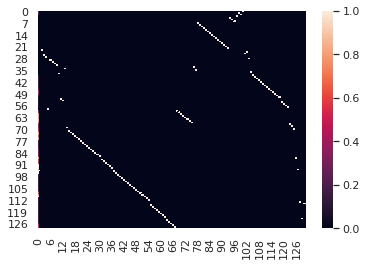

In [102]:
#get the correlation of the columns to influence the number of principal features to pick for training
sns.set_theme()
ax = sns.heatmap(x_train)

#Pick principal features `

In [103]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
principalComponents = pca.fit_transform(x_train)
principalDf = pd.DataFrame(data = principalComponents)

# Working on a sample model


In [112]:
#using KMeans

kmeans = KMeans(
   init="random",
   n_clusters=2,
   n_init=10,
   max_iter=300,
   random_state=42 )
kmeans.fit(principalDf)

# impute missings or nans
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
test = imp.fit_transform(x_test)
predictions  = kmeans.fit_predict(test , sample_weight=1)

In [119]:
type(predictions)

numpy.ndarray

Make submission file

In [116]:
df_submission

,id,target
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0
...,...,...
4995,4995,1
4996,4996,0
4997,4997,1
4998,4998,0


In [129]:
submission_id = df_submission['id']
submission = pd.DataFrame(predictions)
submission['id'] = submission.index
submission.columns = ['target', 'id']

In [131]:
submission = submission[['id', 'target']]

In [132]:
submission.to_csv('submission_1.csv' , deli)